# ACTL3143/5111 Week 4 StoryWall Notebook

## 1. Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from copy import deepcopy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Embedding, Reshape, Dense, Concatenate
from tensorflow.keras.regularizers import l1

from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

## 2. Data Preparation

### 2.1 Load Data

Read in data

In [2]:
from sklearn.datasets import fetch_openml
freq = fetch_openml(data_id=41214, as_frame=True).frame

Examine the data

In [3]:
freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  float64 
 2   Exposure    678013 non-null  float64 
 3   Area        678013 non-null  category
 4   VehPower    678013 non-null  float64 
 5   VehAge      678013 non-null  float64 
 6   DrivAge     678013 non-null  float64 
 7   BonusMalus  678013 non-null  float64 
 8   VehBrand    678013 non-null  category
 9   VehGas      678013 non-null  object  
 10  Density     678013 non-null  float64 
 11  Region      678013 non-null  category
dtypes: category(3), float64(8), object(1)
memory usage: 48.5+ MB


In [4]:
freq.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


### 2.2 Pre-processing

Create a group_id variable as in the dataset there appear to be many observations related to the same policy.

In [5]:
df_freq = freq.iloc[freq.drop(['IDpol','Exposure','ClaimNb'], axis=1).drop_duplicates().index]
df_freq = df_freq.reset_index(drop=True)
df_freq['GroupID'] = df_freq.index+1
df_freq = pd.merge(freq,df_freq, how='left')
df_freq['GroupID'] = df_freq['GroupID'].fillna(method='ffill')

In [6]:
#Group sizes of suspected clusters
df_freq.groupby("GroupID").count()["IDpol"].value_counts()

1      429415
2       83221
3       11597
4        2390
5         675
        ...  
68          1
69          1
147         1
130         1
117         1
Name: IDpol, Length: 125, dtype: int64

As per Noll et al., we apply the following feature pre-processing:
- **VehPower**: 6 categorical classes where >= 9 is grouped together
- **VehAge**: 3 categorical classes $[0,1), [1,10], (10,\infty)$
- **DrivAge**: 7 categorical classes $[18,21), [21,26), [26,31), [31,41), [41 51), [51,71), [71,\infty)$
- **BonusMalus**: continuous feature capped at 150
- **ClaimNb**: integer, capped at 4 - this corrects unreasonable data entries as per F.Loser

These steps reflects homogeneity within class labels and every class label should receive a sufficient volume of observations. They also account for any unreasonable data entries discovered.
(Refer to the paper for further details https://deliverypdf.ssrn.com/delivery.php?ID=609118119089001101090004122093118002032050073078086039018103069073095120119006064070057009021101116003110067093080097064076106009059069023087031030081112016068004034015043026083106109029120125081087120011098111110105003124018105067020119067064028114&EXT=pdf&INDEX=TRUE)

In [7]:
df_freq["ClaimNb"] = df_freq.ClaimNb.clip(upper = 4)
df_freq["VehPower"] = df_freq.VehPower.clip(upper = 9)
df_freq["VehAge"] = pd.cut(df_freq["VehAge"], [np.NINF, 0, 10, np.inf], labels = ["1", "2", "3"])
df_freq["DrivAge"] = pd.cut(df_freq["DrivAge"], [np.NINF, 20, 25, 30, 40, 50, 70, np.inf], labels = ["1", "2", "3", "4", "5", "6", "7"])
df_freq["BonusMalus"] = df_freq.BonusMalus.clip(upper = 150)


In [8]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678013 entries, 0 to 678012
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  float64 
 2   Exposure    678013 non-null  float64 
 3   Area        678013 non-null  category
 4   VehPower    678013 non-null  float64 
 5   VehAge      678013 non-null  category
 6   DrivAge     678013 non-null  category
 7   BonusMalus  678013 non-null  float64 
 8   VehBrand    678013 non-null  category
 9   VehGas      678013 non-null  object  
 10  Density     678013 non-null  float64 
 11  Region      678013 non-null  category
 12  GroupID     678013 non-null  float64 
dtypes: category(5), float64(7), object(1)
memory usage: 49.8+ MB


### 2.3 Split into training and test set

We will perform a stratified sampling / splitting data set based on the GroupID column. This uses GroupShuffleSplit.

In [9]:
df_freq_gss = deepcopy(df_freq)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=999)
split = splitter.split(df_freq_gss, groups=df_freq_gss['GroupID'])
train_inds, test_inds = next(split)
train = df_freq_gss.iloc[train_inds]
test = df_freq_gss.iloc[test_inds]

Repeat for training and val split

In [10]:
train_gss = deepcopy(train)
splitter = GroupShuffleSplit(test_size=0.25, n_splits=2, random_state=999)
split = splitter.split(train_gss, groups=train_gss['GroupID'])
train_inds, val_inds = next(split)
train = train_gss.iloc[train_inds]
val = train_gss.iloc[val_inds]

Check proportion of training set to test set

In [11]:
print(len(train)/len(df_freq_gss))
print(len(test)/len(df_freq_gss))

0.5999000019173674
0.19908615321535134


Check if average claims frequencies are similar between the sets

In [12]:
print(train['ClaimNb'].sum() / train['Exposure'].sum())
print(test['ClaimNb'].sum() / test['Exposure'].sum())

0.10028975631135799
0.10140733979863278


Check the sum of Exposure and count of ClaimNb in the train and test sets.

In [13]:
print(train.groupby(by=['ClaimNb']).agg({'Exposure':['sum'],'ClaimNb':['count']}))
print('\n-------------------------\n')
print(test.groupby(by=['ClaimNb']).agg({'Exposure':['sum'],'ClaimNb':['count']}))

              Exposure ClaimNb
                   sum   count
ClaimNb                       
0.0      202042.084705  386370
1.0       12334.057460   19238
2.0         708.523661    1074
3.0          26.060000      44
4.0           5.960000      14

-------------------------

             Exposure ClaimNb
                  sum   count
ClaimNb                      
0.0      67257.515447  128115
1.0       4169.483080    6488
2.0        222.010951     362
3.0         12.390000      17
4.0          0.080000       1


In [14]:
## Usual splitting method
#target = df_freq['ClaimNb']
#features = df_freq.drop(['ClaimNb'], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=2022)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2022)

Splitting into X and y (separate features and targets)

In [15]:
y_train = train['ClaimNb']
X_train = train.drop(['ClaimNb'], axis=1)

y_val = train['ClaimNb']
X_val= train.drop(['ClaimNb'], axis=1)

y_test = test['ClaimNb']
X_test = test.drop(['ClaimNb'], axis=1)

### 2.4 Further Processing

Transform the categorical variables to integers

In [16]:
NUM_BRANDS, NUM_REGIONS = X_train.nunique()[["VehBrand", "Region"]]

ct = make_column_transformer(
  (OrdinalEncoder(), ["VehBrand", "Region", "Area", "VehGas","VehAge","DrivAge"]),
  remainder=StandardScaler()
)

X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.fit_transform(X_val)
X_test_ct = ct.transform(X_test)

# 3. Modelling

## 3.1 Organise the inputs

Split the brand and region data apart from the rest

In [17]:
X_train_brand = X_train_ct[:,0]; X_val_brand = X_train_ct[:,0]; X_test_brand = X_test_ct[:,0]
X_train_region = X_train_ct[:,1]; X_val_region = X_train_ct[:,1]; X_test_region = X_test_ct[:,1]
X_train_rest = X_train_ct[:,2:]; X_val_rest = X_train_ct[:,2]; X_test_rest = X_test_ct[:,2:]

Make a Keras Input for: vehical brand, region and others

In [18]:
vehBrand = Input(shape=(1,), name="vehBrand")
region = Input(shape=(1,), name="region")
otherInputs = Input(shape=X_train_rest.shape[1:], name="otherInputs")

Create embeddings and join them with the other inputs.


In [19]:
tf.random.set_seed(2022)
vehBrandEE = Embedding(input_dim=NUM_BRANDS, output_dim=2,
    name="vehBrandEE")(vehBrand)
vehBrandEE = Reshape(target_shape=(2,))(vehBrandEE)

regionEE = Embedding(input_dim=NUM_REGIONS, output_dim=2,
    name="regionEE")(region)
regionEE = Reshape(target_shape=(2,))(regionEE)

x = Concatenate(name="combined")([vehBrandEE, regionEE, otherInputs])

## 3.2 Complete the model and fit it

In [20]:
x = Dense(32, "relu", kernel_regularizer=l1(0.01),name="hidden1")(x)
x = Dense(16, "relu", kernel_regularizer=l1(0.01),name="hidden2")(x)
out = Dense(1, "exponential", name="out")(x)

model = Model([vehBrand, region, otherInputs], out)
model.compile(optimizer="adam", loss="poisson", metrics=["accuracy"])

hist = model.fit((X_train_brand, X_train_region, X_train_rest),
    y_train, 
    epochs=100, 
    callbacks=[EarlyStopping(patience=5)],
    validation_split = 0.2
    )
    
np.min(hist.history["val_loss"])

Epoch 1/100
10169/10169 [==============================] - 9s 822us/step - loss: 0.2670 - accuracy: 0.9440 - val_loss: 0.1502 - val_accuracy: 0.9705
Epoch 2/100
10169/10169 [==============================] - 8s 811us/step - loss: 0.2256 - accuracy: 0.9448 - val_loss: 0.1500 - val_accuracy: 0.9705
Epoch 3/100
10169/10169 [==============================] - 9s 868us/step - loss: 0.2256 - accuracy: 0.9448 - val_loss: 0.1486 - val_accuracy: 0.9705
Epoch 4/100
10169/10169 [==============================] - 8s 833us/step - loss: 0.2256 - accuracy: 0.9448 - val_loss: 0.1498 - val_accuracy: 0.9705
Epoch 5/100
10169/10169 [==============================] - 8s 808us/step - loss: 0.2255 - accuracy: 0.9448 - val_loss: 0.1508 - val_accuracy: 0.9705
Epoch 6/100
10169/10169 [==============================] - 8s 820us/step - loss: 0.2256 - accuracy: 0.9448 - val_loss: 0.1500 - val_accuracy: 0.9705
Epoch 7/100
10169/10169 [==============================] - 8s 810us/step - loss: 0.2256 - accuracy: 0.9448

0.14842279255390167

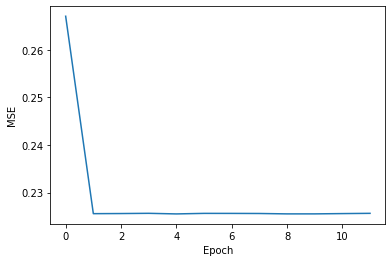

In [22]:
plt.plot(hist.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE");

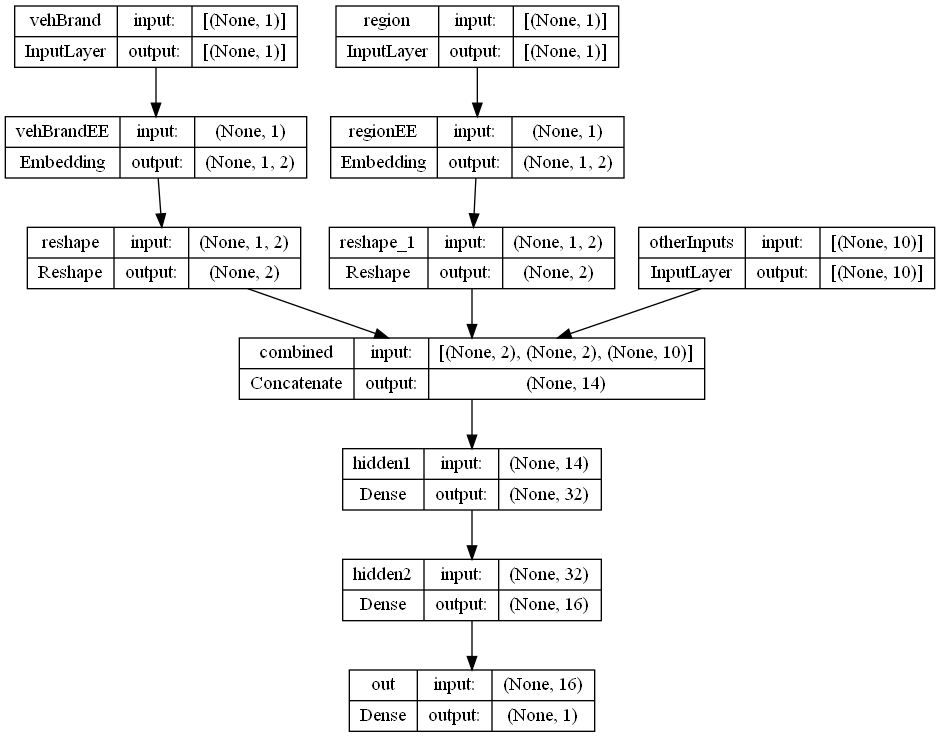

In [23]:
plot_model(model, show_shapes=True)

## 3.3 Model Evaluation

Evaluate the model

In [24]:
model.evaluate((X_test_brand, X_test_region, X_test_rest), y_test)

4219/4219 [==============================] - 2s 583us/step - loss: 0.2125 - accuracy: 0.9491


[0.21245254576206207, 0.949119508266449]

Make the predictions on test data

In [50]:
y_pred = model.predict((X_test_brand, X_test_region, X_test_rest))
y_pred


4219/4219 [==============================] - 2s 511us/step


array([[0.05750427],
       [0.05750417],
       [0.05750425],
       ...,
       [0.05750408],
       [0.05750411],
       [0.05750414]], dtype=float32)

In [36]:
np.mean(y_pred)

0.05750423

In [47]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ["Prediction"]
y_pred_df

,Prediction
0,0.057504
1,0.057504
2,0.057504
3,0.057504
4,0.057504
...,...
134978,0.057504
134979,0.057504
134980,0.057504
134981,0.057504


In [46]:
print(y_pred_df.groupby(by=['Prediction']).agg({'Prediction':['count']}))

           Prediction
                count
Prediction           
0              134983
